In [1]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *

In [21]:
"""
Even the simple XOR system has 8 dimensions of evolutions:
- This model does not always learn
- Highly depends on the initialization
- The minibatch is not helping here (not enough inputs: no estimation of gradient)
"""

class MaximumModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))
    
    def forward(self, x):
        x = self.model(x)
        return x

def train(xs, ys):
    data_set = TensorDataset(xs, ys)
    data_loader = DataLoader(data_set, batch_size=100, shuffle=True)

    model = MaximumModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(1000):
        cumulative_loss = 0.
        for inputs, expected in data_loader:
            optimizer.zero_grad()
            got = model(inputs)
            loss = criterion(got, expected.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()
        if epoch % 100 == 0:
            print(cumulative_loss)
    return model

n = 1000
xs = np.random.uniform(-5, 5, size=2*n).reshape((n, 2))
ys = np.apply_along_axis(lambda x: max(x), axis=-1, arr=xs)

xs = torch.tensor(xs, dtype=torch.float32, requires_grad=False)
ys = torch.tensor(ys, dtype=torch.float32, requires_grad=False)
model = train(xs, ys)

79.41660404205322
0.00031899770328891464
0.00012811376905119687
0.00011882758644787828
0.019658473684103228
0.8433895418420434
0.025898572814185172
0.003969318553572521
7.839351525262828e-06
0.0025544871932652313


In [22]:
def predict(model, xs):
    xs = torch.tensor(xs, dtype=torch.float32, requires_grad=False)
    ys = model(xs)
    return ys.detach().numpy()

# Works great for inputs it has seen
print(predict(model, [[1.5, -1.5], [-1.5, -2.5], [2, 3]]))

# Does not work that great outside of the training interval
print(predict(model, [[-10, -11], [10, 11], [10, -10]]))

[[ 1.5691013]
 [-1.4501865]
 [ 3.1062284]]
[[-4.6807637]
 [11.306477 ]
 [10.024773 ]]


In [25]:
"""
Same idea, but this time the classifier will just return the index of the maximum value
"""

class MaximumIndexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 2))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, with_softmax=True):
        x = self.model(x)
        if with_softmax:
            x = self.softmax(x)
        return x

def train(xs, ys):
    data_set = TensorDataset(xs, ys)
    data_loader = DataLoader(data_set, batch_size=100, shuffle=True)

    model = MaximumIndexModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(1000):
        cumulative_loss = 0.
        for inputs, expected in data_loader:
            optimizer.zero_grad()
            got = model(inputs, with_softmax=False)
            loss = criterion(got, expected)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()
        if epoch % 100 == 0:
            print(cumulative_loss)
    return model

n = 1000
xs = np.random.uniform(-5, 5, size=2*n).reshape((n, 2))
ys = np.apply_along_axis(lambda x: 0 if x[0] >= x[1] else 1, axis=-1, arr=xs)

xs = torch.tensor(xs, dtype=torch.float32, requires_grad=False)
ys = torch.tensor(ys, dtype=torch.long, requires_grad=False)
model = train(xs, ys)

3.232817992568016
0.2702178319450468
0.18278778492094716
0.15379493188811466
0.11609094208688475
0.18232797240489163
0.06846127461176366
0.05554319115799444
0.42604836699320003
0.06338563692406751


In [38]:
def predict(model, inputs):
    xs = torch.tensor(inputs, dtype=torch.float32, requires_grad=False)
    ys = model(xs)
    ys = torch.argmax(xs, dim=-1)
    return [inputs[i][j] for i, j in enumerate(ys)]

# Now it works great for any kind of inputs
print(predict(model, [[1.5, -1.5], [-1.5, -2.5], [2, 3]]))
print(predict(model, [[-10, -11], [10, 11], [10, -10]]))

[1.5, -1.5, 3]
[-10, 11, 10]


In [ ]:
"""
Same idea, but this time, we use a sequence of any kind of length (using LSTM)
"""

# TODO

X: layer 0 position (0, 0)
Y: layer 0 position (0, 1)


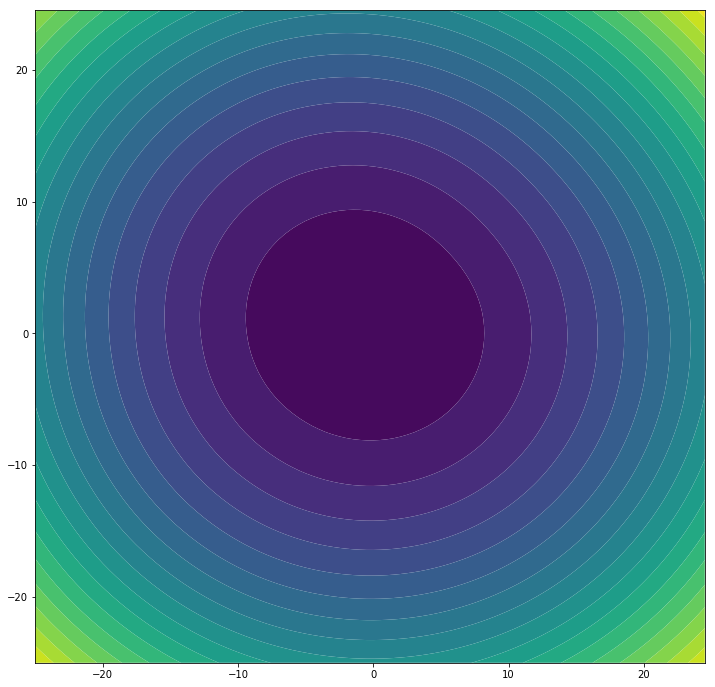

X: layer 0 position (0, 0)
Y: layer 0 position (1, 0)


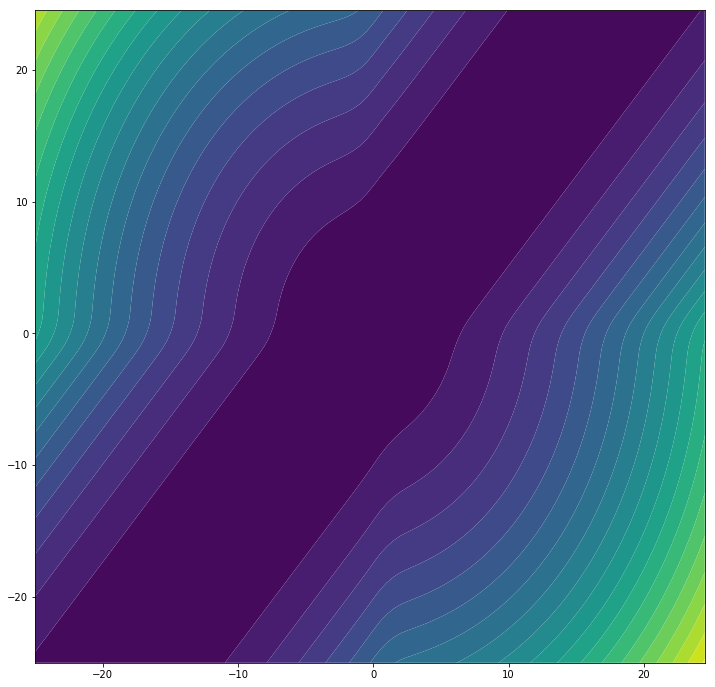

X: layer 0 position (0, 0)
Y: layer 0 position (1, 1)


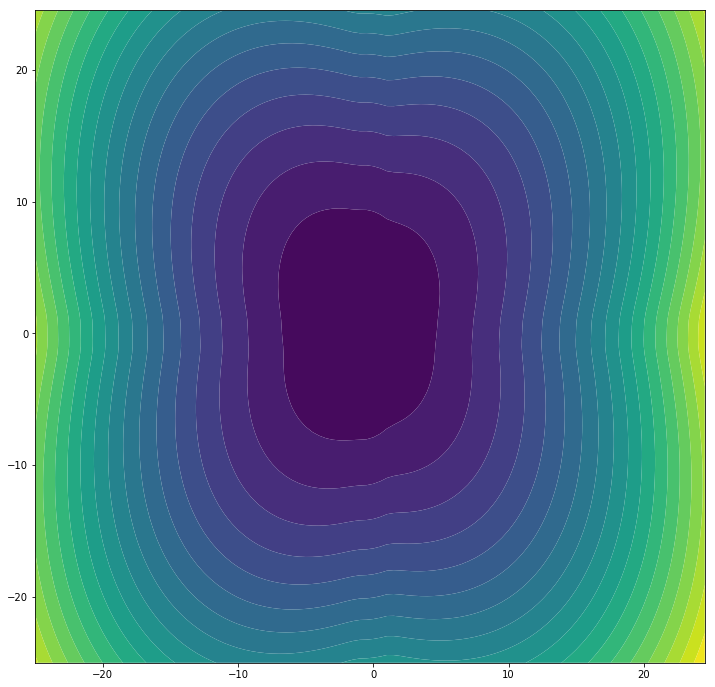

X: layer 0 position (0, 0)
Y: layer 2 position (0, 0)


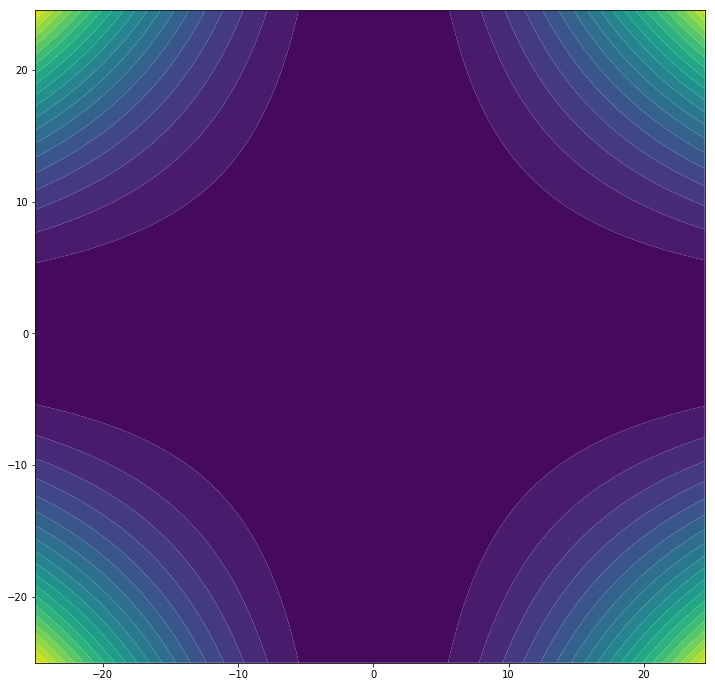

X: layer 0 position (0, 0)
Y: layer 2 position (0, 1)


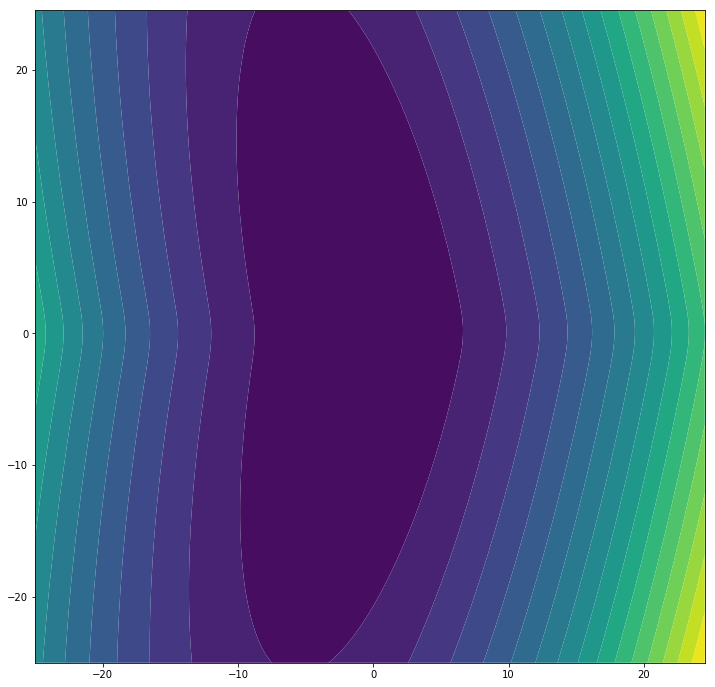

X: layer 0 position (0, 1)
Y: layer 0 position (1, 0)


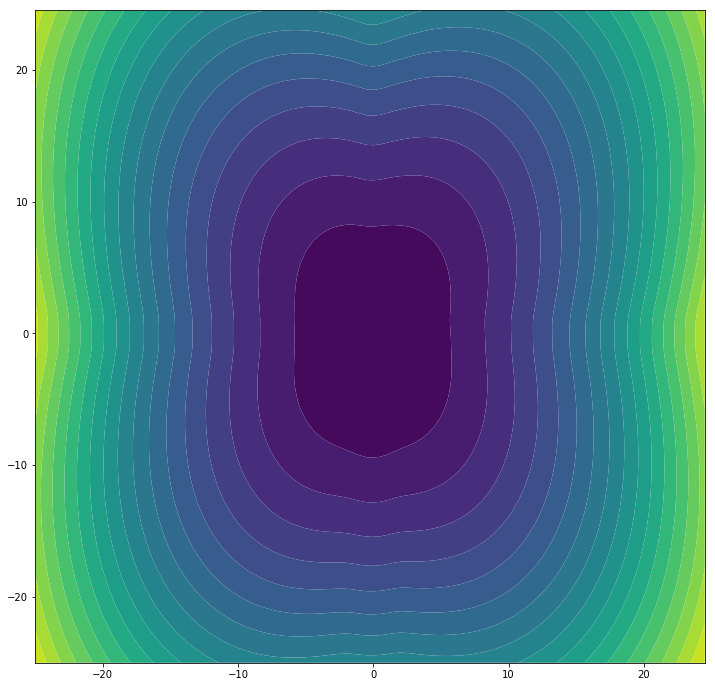

X: layer 0 position (0, 1)
Y: layer 0 position (1, 1)


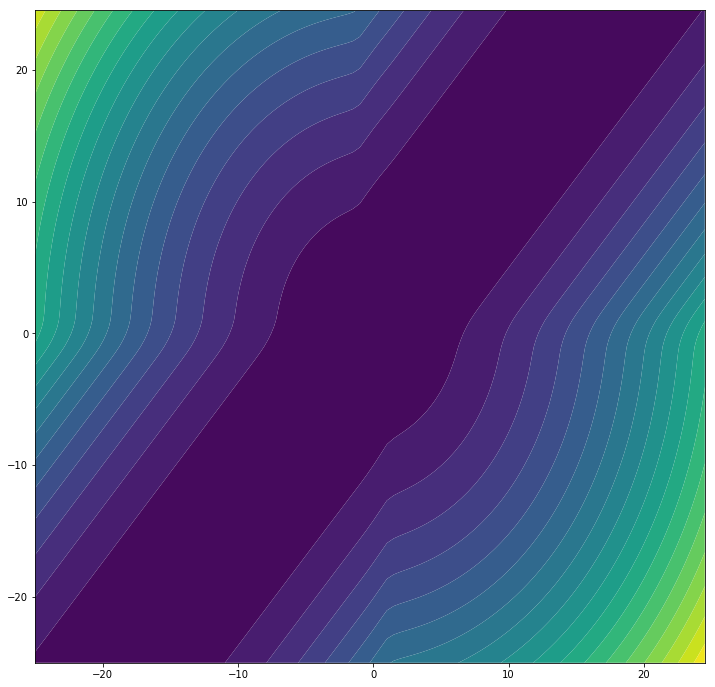

X: layer 0 position (0, 1)
Y: layer 2 position (0, 0)


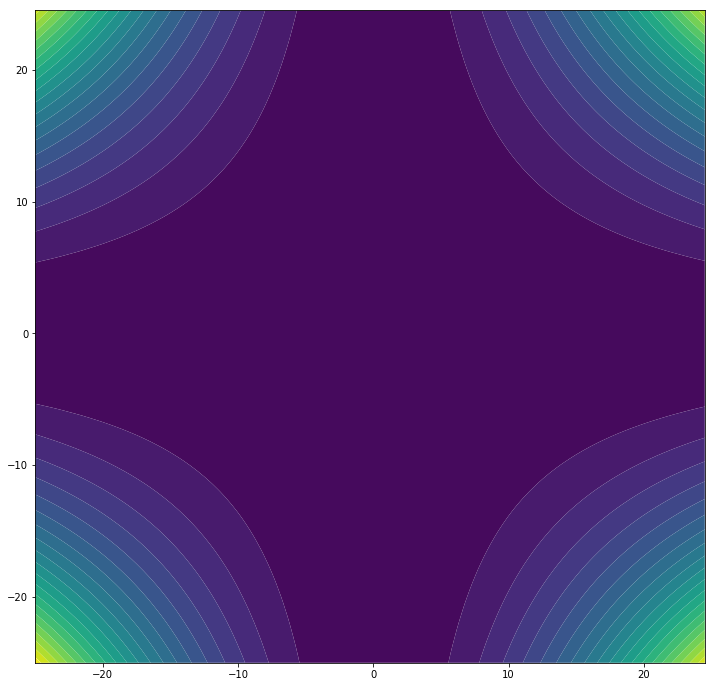

X: layer 0 position (0, 1)
Y: layer 2 position (0, 1)


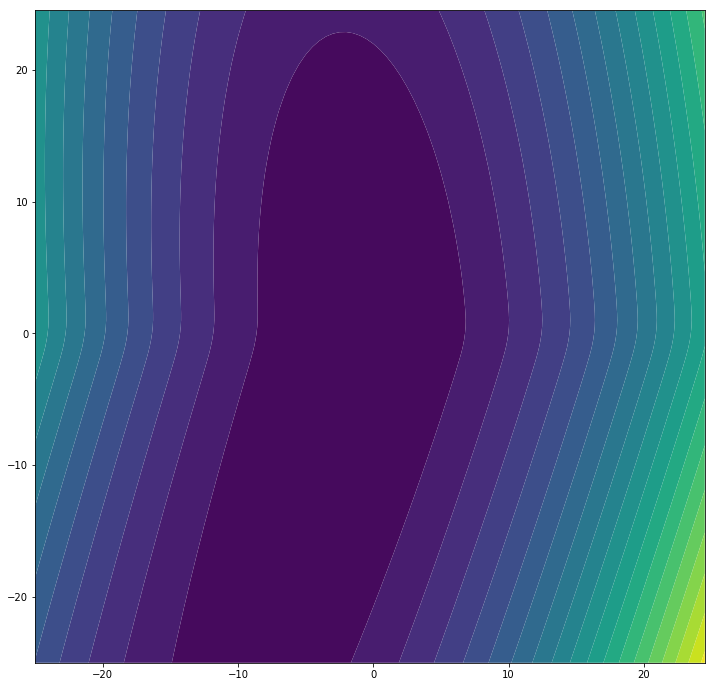

X: layer 0 position (1, 0)
Y: layer 0 position (1, 1)


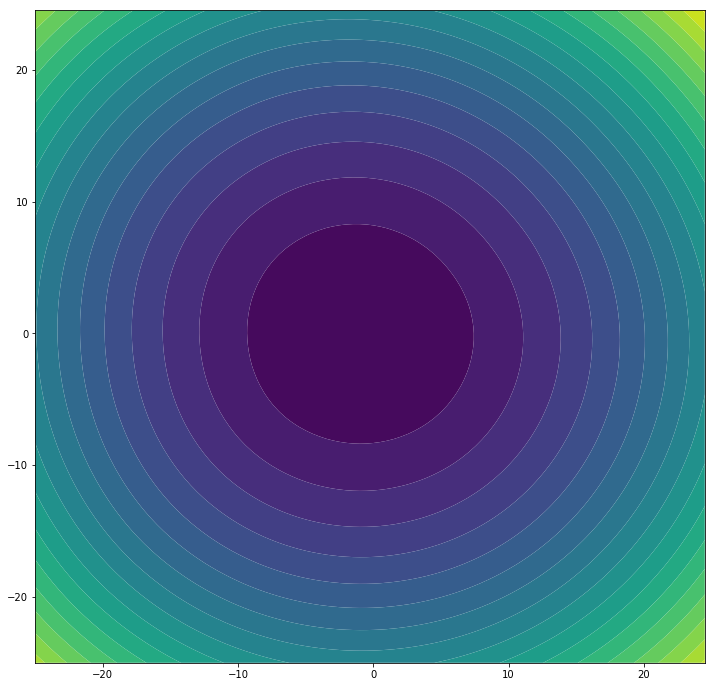

X: layer 0 position (1, 0)
Y: layer 2 position (0, 0)


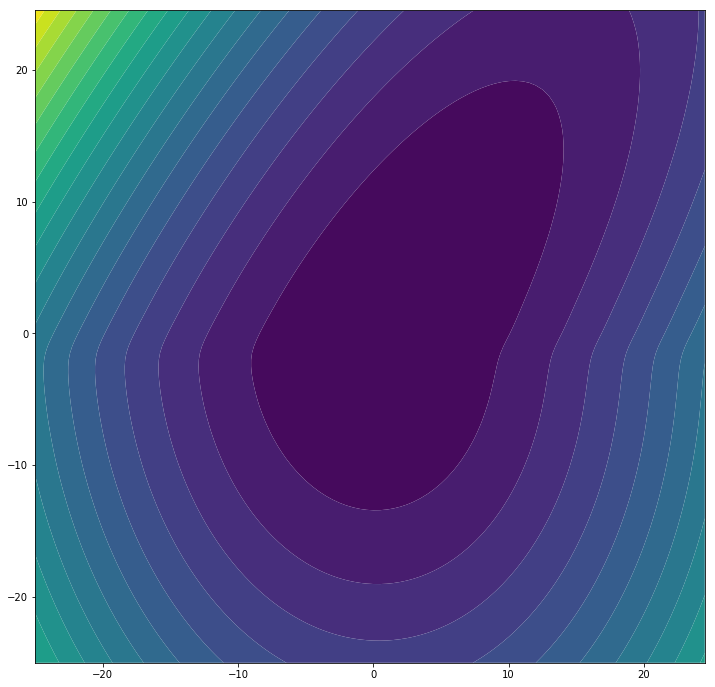

X: layer 0 position (1, 0)
Y: layer 2 position (0, 1)


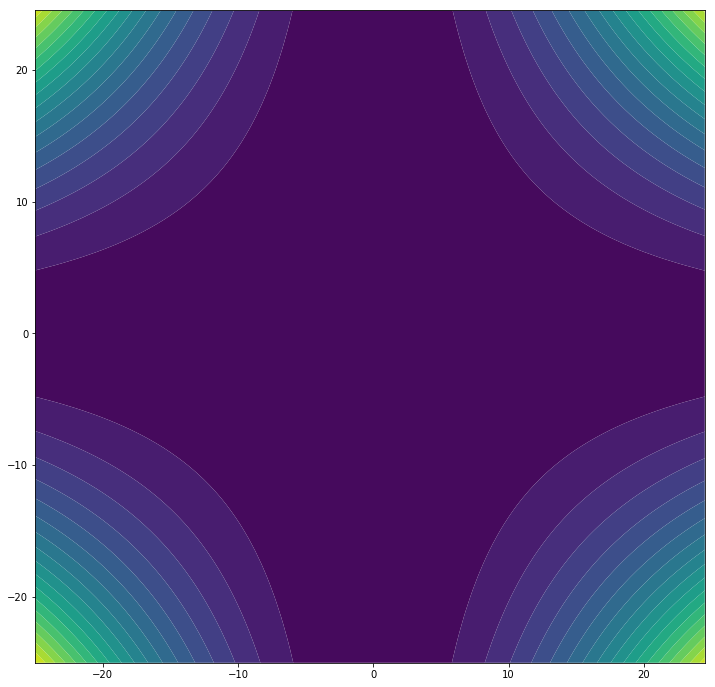

X: layer 0 position (1, 1)
Y: layer 2 position (0, 0)


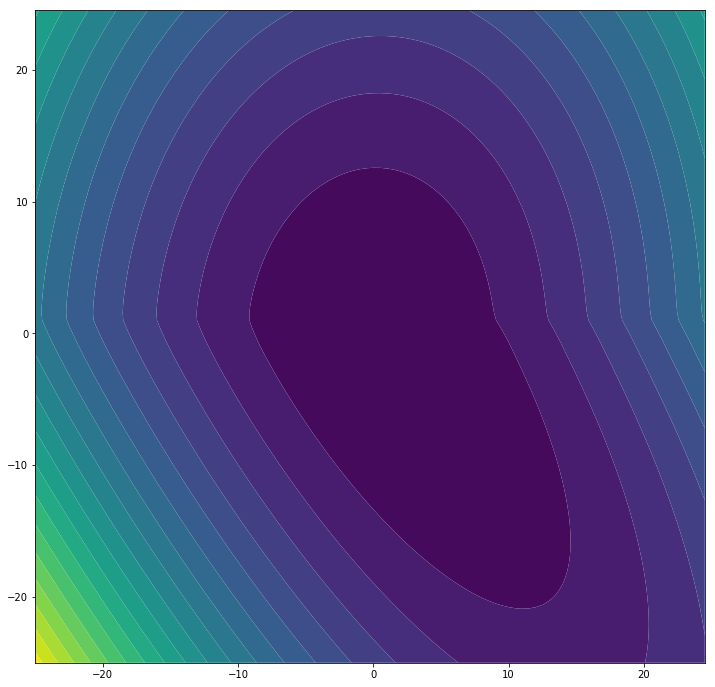

X: layer 0 position (1, 1)
Y: layer 2 position (0, 1)


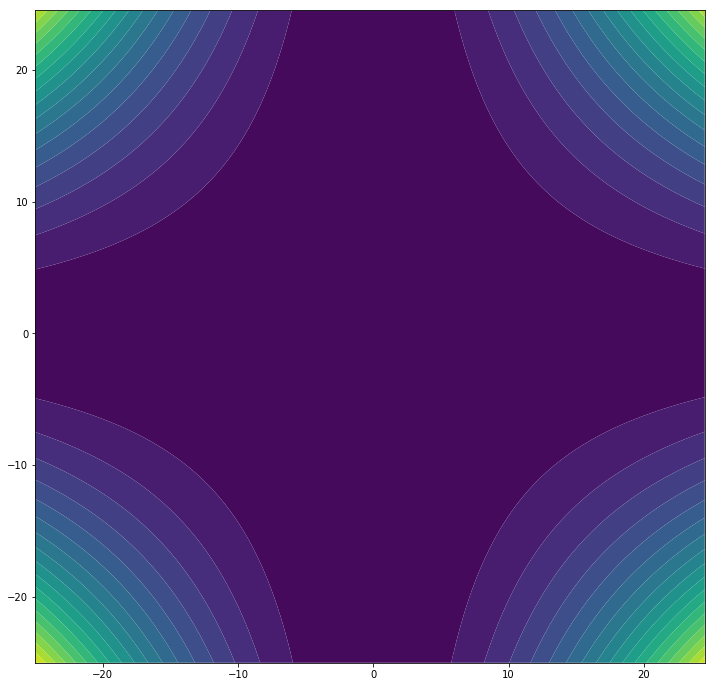

X: layer 2 position (0, 0)
Y: layer 2 position (0, 1)


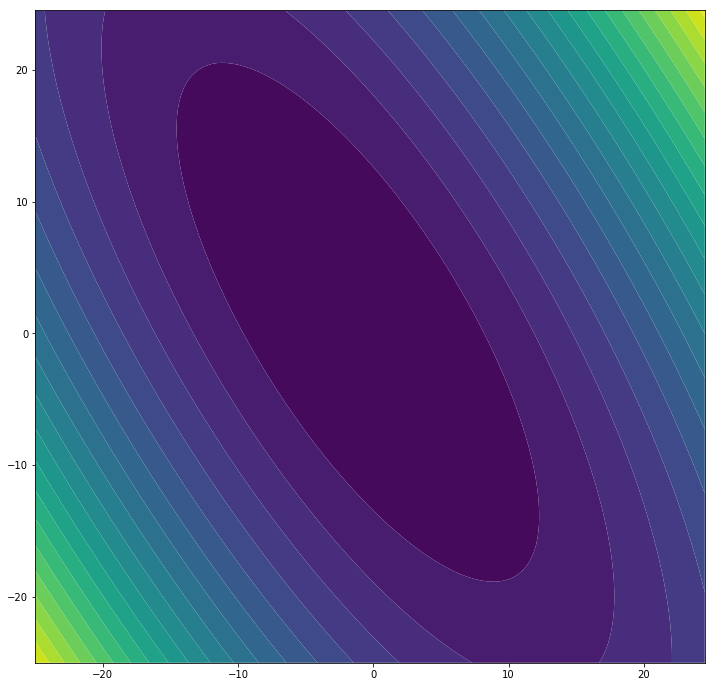

In [17]:
"""
Displaying the loss as contour map, for each of the neurons
"""

import copy

def contour_map(original_model):        
    inputs = xs
    expected = ys.unsqueeze(-1)
    criterion = nn.MSELoss()
    
    X = np.arange(-25.0, 25.0, 0.5)
    Y = np.arange(-25.0, 25.0, 0.5)
    n = len(X)
    m = len(Y)
    
    axes = [
        (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), # Layer 1
        (2, 0, 0), (2, 0, 1)                        # Layer 2
    ]
    for axe_i in range(len(axes)):
        for axe_j in range(axe_i + 1, len(axes)):
            model = MaximumModel()
            model.load_state_dict(copy.deepcopy(original_model.state_dict()))
            model.eval()
            
            a, b, c = axes[axe_i]
            d, e, f = axes[axe_j]
            
            print("X: layer", a, "position", (b, c))
            print("Y: layer", d, "position", (e, f))
            
            losses = np.zeros(n * m).reshape((n, m))
            for i in range(n):
                for j in range(m):
                    model.model[a].weight[(b, c)] = X[i]
                    model.model[d].weight[(e, f)] = Y[j]
                    losses[(i, j)] = criterion(model(inputs), expected)

            fig, ax = plt.subplots(figsize=(12, 12))
            CS = ax.contourf(X, Y, losses, levels=20, antialiased=True)
            # CS = ax.contour(X, Y, losses, levels=20, linewidths=3, antialiased=True)
            # ax.clabel(CS, inline=1, fontsize=14)
            plt.show()

contour_map(model)